In [1]:
import sys, os
sys.path.insert(0, os.path.abspath('..'))
from marl_aquarium.aquarium_v0 import parallel_env

import time
from utils.OpenAI_ES import *
from utils.env_utils import *
from utils.train_utils import *
from utils.eval_utils import *
from models.Buffer import Buffer, Pool
from models.Discriminator import Discriminator
from models.Generator import GeneratorPolicy
from collections import deque 
import random
import pickle
from marl_aquarium.env.utils import scale
import cv2
import gym

In [2]:
# Training Folder
path = r"..\data\training"
timestamp = datetime.datetime.now().strftime("%d.%m.%Y_%H.%M")
folder_name = f"Training - {timestamp}"

save_dir = os.path.join(path, folder_name)
os.makedirs(save_dir, exist_ok=True)

data_path = r"..\data\processed\video_8min\expert_tensors"
buffer_path = r"..\data\buffer"

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

pred_policy = GeneratorPolicy().to(device)
pred_policy.set_parameters(init=True)

prey_policy = GeneratorPolicy().to(device)
prey_policy.set_parameters(init=True)

pred_discriminator = Discriminator().to(device)
pred_discriminator.set_parameters(init=True)
optim_dis_pred = torch.optim.RMSprop(pred_discriminator.parameters(), lr=0.01, alpha=0.99, eps=0.2)

prey_discriminator = Discriminator().to(device)
prey_discriminator.set_parameters(init=True)
optim_dis_prey = torch.optim.RMSprop(prey_discriminator.parameters(), lr=0.01, alpha=0.99, eps=0.2)

expert_buffer = Buffer(pred_max_length=1000, prey_max_length=32000, device=device)
generative_buffer = Buffer(pred_max_length=1000, prey_max_length=32000, device=device)

early_stopper_pred = EarlyStopping(patience=20)
early_stopper_prey = EarlyStopping(patience=20)

In [4]:
print("Expert Buffer is empty, load data...")
expert_buffer.add_expert(data_path, window_size=1, detections=33)
len_exp_pred, len_exp_prey = expert_buffer.lengths()

print("Storage of Predator Expert Buffer: ", len_exp_pred)
print("Storage of Prey Expert Buffer: ", len_exp_prey, "\n")

Expert Buffer is empty, load data...
Storage of Predator Expert Buffer:  742
Storage of Prey Expert Buffer:  23744 



In [5]:
video = "video_8min"
num_frames=1
total_detections=33

raw_video_folder = r'..\data\raw\videos'
video_path = raw_video_folder + "\\" + video + ".mp4"

yolo_path = r'..\models\costumized_yolo\costumized_yolo\costumized_yolo.pt'
processed_video_folder = rf'..\data\processed\{video}'

os.makedirs(os.path.join(processed_video_folder, "full_track_windows"), exist_ok=True)
ftw_path = os.path.join(processed_video_folder, "full_track_windows", f"full_track_windows_{total_detections}.pkl")
vw_path = os.path.join(processed_video_folder, "full_track_windows", f"valid_windows_{total_detections}.pkl")

if os.path.exists(ftw_path) and os.path.exists(vw_path):
    with open(ftw_path, "rb") as f:
        full_track_windows = pickle.load(f)

    with open(vw_path, "rb") as f:
        valid_windows = pickle.load(f)

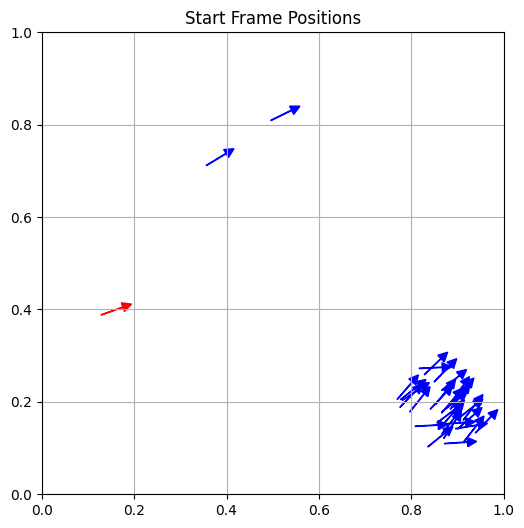

In [6]:
start_frame_pool = Pool(max_length=1000, device=device)
start_frame_pool.generate_startframes(video_path, full_track_windows) #n=742
positions = start_frame_pool.sample(n=1)

fig, ax = plt.subplots(figsize=(6, 6))
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.set_aspect('equal')
ax.set_title("Start Frame Positions")

arrow_length = 0.05

for idx, (x, y, angle) in enumerate(positions):
    dx = arrow_length * np.cos(angle)
    dy = arrow_length * np.sin(angle)
    color = 'red' if idx == 0 else 'blue'
    ax.arrow(x, y, dx, dy, head_width=0.02, head_length=0.02, fc=color, ec=color)

plt.grid(True)
plt.show()

In [7]:
env = parallel_env(predator_count=1, prey_count=32, action_count=360, use_walls=True)
positions = start_frame_pool.sample(n=1)
obs, infos = env.reset(options=positions)

while not keyboard.is_pressed('q'):
    
    global_state = env.state().item()

    pred_tensor, prey_tensor, xs, ys, dx, dy, vxs, vys = get_eval_features(global_state)

    pred_states = pred_tensor[..., :4]
    con_pred = pred_policy.forward_pred(pred_states)
    dis_pred = continuous_to_discrete(con_pred, 360, role='predator')

    prey_states = prey_tensor[..., :4]
    con_prey = prey_policy.forward_prey(prey_states)
    dis_prey = continuous_to_discrete(con_prey, 360, role='prey')

    action_dict = {'predator_0': dis_pred}

    for i, agent_name in enumerate(sorted([agent for agent in env.agents if agent.startswith("prey")])):
        action_dict[agent_name] = dis_prey[i]

    env.step(action_dict)
    
    env.render()

SystemExit: 

c:\Users\janni\anaconda3\envs\GAIL\lib\site-packages\IPython\core\interactiveshell.py:3587: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)
